In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture #For GMM clustering

# Problem definition

Cluster reviews by different characteristics: reviewer age, rating, sentiment, product type, etc...

In [2]:
#input
df = pd.read_csv("../data/Cleaned-womens-ecommerce-clothing-reviews.csv")
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommendation,Positive Feedback Count,Division Name,Product Category,clothes type,reviews
0,767,33,Love it!,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Love it! - Absolutely wonderful - silky and se...
1,1080,34,Love it!,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love it! - Love this dress! it's sooo pretty....
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws - I had such high hope...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! - I love, love, love this jum..."
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt - This shirt is very flatteri...


In [3]:
# Delet all the cloumns that I don't need
df_k_means=df.drop(['Clothing ID','Title','Review Text','Product Category','Division Name','Recommendation'],axis=1)

Text can be converted to a numerical value using sentiment scores. The way to do this is to use predefined sentiment lexicons and match them accordingly. For that, I will use the AFINN lexicon.

In [4]:
from afinn import Afinn

afinn= Afinn()
afinn_scores = [afinn.score(reviews) for reviews in df.reviews]
df['afinn'] = afinn_scores
df[['afinn', 'reviews']].head(10)


,afinn,reviews
0,12.0,Love it! - Absolutely wonderful - silky and se...
1,15.0,Love it! - Love this dress! it's sooo pretty....
2,3.0,Some major design flaws - I had such high hope...
3,24.0,"My favorite buy! - I love, love, love this jum..."
4,6.0,Flattering shirt - This shirt is very flatteri...
5,7.0,Not for the very petite - I love tracy reese d...
6,1.0,Cagrcoal shimmer fun - I aded this in my baske...
7,2.0,"Shimmer, surprisingly goes with lots - I order..."
8,3.0,Flattering - I love this dress. i usually get ...
9,14.0,"Such a fun dress! - I'm 5""5' and 125 lbs. i or..."


In [5]:
df_k_means['reviews'] = df_k_means['reviews'].str.lower()
df_k_means['sent_score'] = df_k_means.apply(lambda row: afinn.score(row['reviews']), axis=1)

sent_score = df_k_means['sent_score'].values

# A negative value denotes negative sentiment and a positive score indicates positive sentiments.
# The scores that are returned are then stored in a .txt format and called using the pickle.load function.

import pickle
with open("sent.txt", "wb") as fp: #Pickling 
    pickle.dump(sent_score, fp)

with open("sent.txt", "rb") as fp: # Unpickling 
    b = pickle.load(fp)

print(b)


[12. 15.  3. ... 11. 19. 12.]


In [6]:
df_k_means['sent_score'] = b

# adding the minimum value of sentiment score so as to remove negative sentiment scores
min_sent = abs(np.min(df_k_means['sent_score']))
df_k_means['sent_score'] =  df_k_means['sent_score'] + abs(np.min(df_k_means['sent_score']))
df_k_means.drop('reviews',axis=1,inplace=True)


In [7]:
df_k_means.columns = ['Age','Rating','N_Positive Feedback','clothes','sent_score']
del df_k_means['clothes']

In [8]:
# remove NaNs
df_k_means = df_k_means.dropna()
df_k_means.head()

,Age,Rating,N_Positive Feedback,sent_score
0,33,4,0,28.0
1,34,5,4,31.0
2,60,3,0,19.0
3,50,5,0,40.0
4,47,5,6,22.0


In [9]:
# df_k_means.clothes.value_counts()

In [10]:
# I will apply dummies on the clothes variable in order to change its data type to numeric.
# pd.get_dummies(df_k_means.clothes, prefix = 'clothes')
#print(df_k_means)

/home/leen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


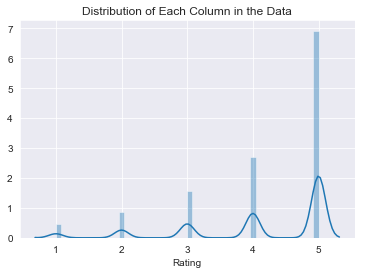

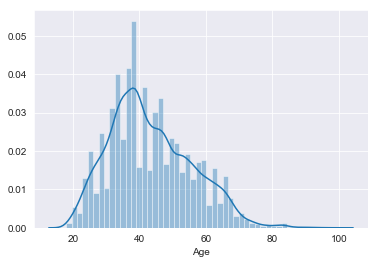

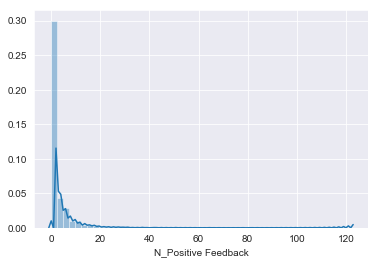

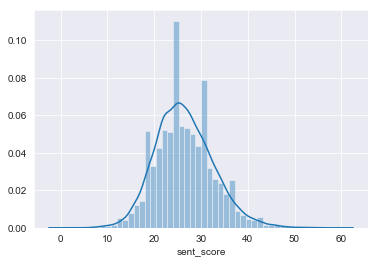

In [11]:
# plot the data distribuation:
sns.set_style('darkgrid')
plt.title('Distribution of Each Column in the Data')

for i,col in enumerate(df_k_means.columns):
    plt.figure(i)
    sns.distplot(df_k_means[col])

My data is indeed not normally distributed. Since K Means algorithm do not handle skewed distributions well. I have To transform each variable to a normal distrbution.

# Feature Engineering 

In [12]:
# from scipy.stats import boxcox
# tmp = df_k_means 
# # adding one to each data variable to make it positive
# tmp = tmp+1
# for i in tmp.columns:
#     tmp[i]=np.log(tmp[i])
# # log modified data    
# df_mod = tmp
# # checking the distributions after transforming
# sns.set_style('darkgrid')
# plt.title('Distribution of Each Column in the Data')

# for i,col in enumerate(df_mod.columns):
#     plt.figure(i)
#     sns.distplot(df_mod[col])

In [13]:
# normalize the columns
df_k_means_norm = df_k_means.copy()

X_columns = list(df_k_means.columns)


for col in X_columns:
    df_k_means_norm[col] = StandardScaler().fit_transform(df_k_means_norm[col].values.reshape(-1, 1))

print(df_k_means_norm.shape)
df_k_means_norm.head()

(22628, 4)


/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with i

,Age,Rating,N_Positive Feedback,sent_score
0,-0.834114,-0.164077,-0.454744,0.253309
1,-0.752997,0.732071,0.236413,0.738129
2,1.356039,-1.060226,-0.454744,-1.201152
3,0.544871,0.732071,-0.454744,2.192589
4,0.301521,0.732071,0.581992,-0.716332


# Model Training

In [14]:
k = 6
kmeans = KMeans(n_clusters=k).fit(df_k_means_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df_k_means.copy()
df_k_means_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2, 3, 4, 5}
Counter({5: 7011, 3: 5138, 0: 4972, 1: 4328, 2: 1074, 4: 105})


In [15]:
# To be more clear:
size_of_each_cluster = df_k_means_norm.groupby('cluster').size().reset_index()
size_of_each_cluster.columns = ['cluster','number_of_points']
size_of_each_cluster['percentage'] = size_of_each_cluster['number_of_points']/np.sum(size_of_each_cluster['number_of_points'])

print(size_of_each_cluster)

   cluster  number_of_points  percentage
0        0              4972    0.219728
1        1              4328    0.191267
2        2              1074    0.047463
3        3              5138    0.227064
4        4               105    0.004640
5        5              7011    0.309837



Clusters 2 and 5 have an equal percentage of points which is 23%, cluster 4 has not that much of the points, the rest of the clusters have nearly equal percentage of data pointsm each of them has around 16%.

Age


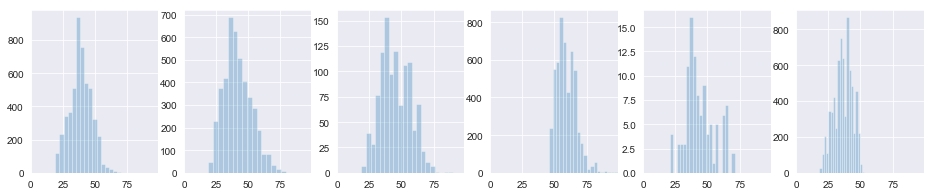

Rating


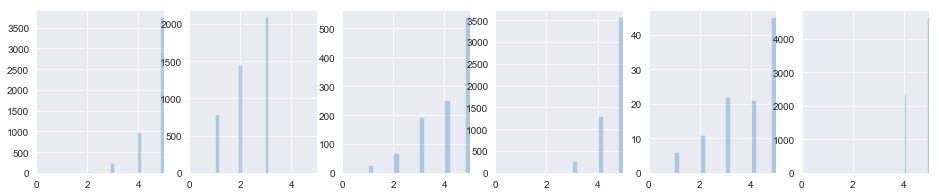

N_Positive Feedback


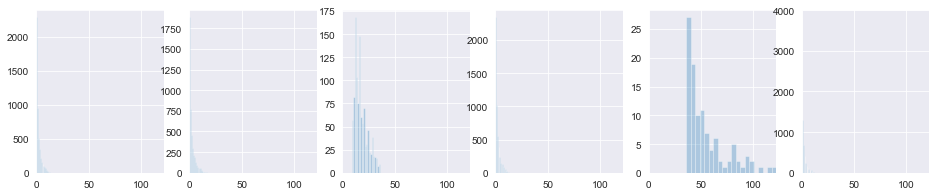

sent_score


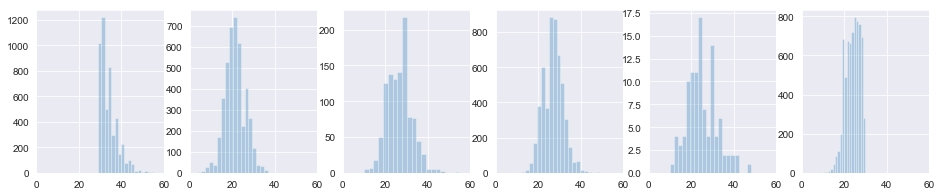

In [16]:
# Analyze the results
# df_results = df_results.reset_index()
# for cluster in sorted(set(kmeans.labels_)):
#     print(collections.Counter(df_results[df_results['cluster']==cluster]['clothes']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [17]:
''# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5
Age,38.31,41.36,45.31,59.06,43.64,36.11
Rating,4.70,2.30,4.12,4.64,3.84,4.66
N_Positive Feedback,1.73,2.06,17.69,1.67,54.48,1.25
sent_score,33.99,21.40,26.54,26.91,25.10,23.83


Age


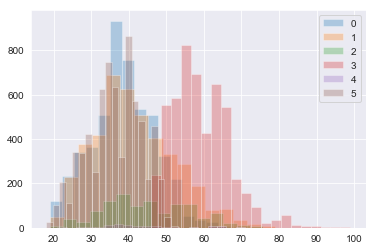

Rating


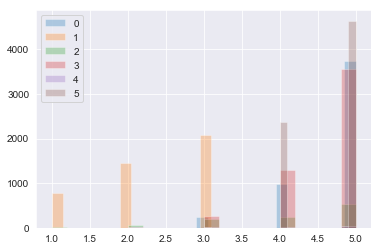

N_Positive Feedback


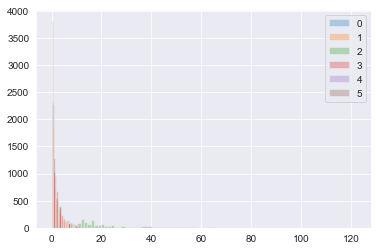

sent_score


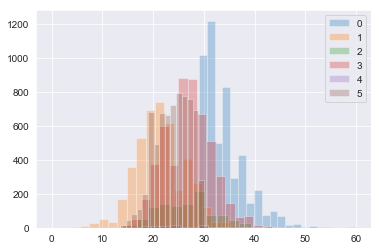

In [18]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

# Model Evaluation

In [19]:
from sklearn.metrics.pairwise import euclidean_distances
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_k_means_norm[df_k_means_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_k_means_norm[df_k_means_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_k_means_norm[df_k_means_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 0.6220862022960397
Intra Cluster distance 0.5523775698547951
Inertia 35297.62948575146


The Inter cluster distance should be bigger than what I had

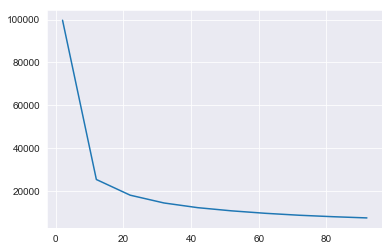

In [20]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_k_means_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

Describe the clusters:

* Cluster 0 : Fairly positive sentiments but with Low number of positive feedback and high rate reviews from fairly young women.     
* Cluster 1 : Negative sentiments but with Low number of positive feedback and low rate reviews from fairly Middle age  women.
* Cluster 2 : Fairly negative sentiments but with good number of positive feedback and high rate reviews from fairly middle age women.
* Cluster 3 : Fairly negative sentiments from Older women who gave good rating and very low number of positive feedback.
* Cluster 4 : Fairly negative sentiments from a Middle age women with a very Hight number of positive feedback .
* Cluster 5 : Fairly negative sentiment from young women with good rate of reviews and very low number of positive feedback.